**Quant Model: Multiple Signals**

Decile Formation based on combining b2m and accruals signals, and Long Short Portfolio Returns calculation





**Data Description and code sequence**

Important Dataframes

1.  "Returns" dataframe : It contains monthly returns(RET), shares  outstanding (SHROUT) values, Price (PRC), Primary Exchange Code (PRIMEXCH) and  Unique Identifiers (PERMNO). The data are downloaded from  CRSP.

Key Input data:
date:    yyyymmdd format
RET:     return for the month ending yyyymmdd
EXCHCD:  Exchange where listed
PRC:   Price as of month-end
SHROUT:  Shares outstanding as of month ending yyyymmdd


2.   "Cstat_data" dataframe : Compustat data used to construct signals

  LPERMNO: CRSP identifier - relable to PERMNO to merge
  ceq: book value of common equity
  Accurals = (Income before extraordinary items (ib) - Cash flow (oancf))/ total assets (at)

  #normalized by total assetes so that accruals are comparable across stocks of different sizes



3. merged_data : Dataframe obtained from Merging "Returns" & "Cstat_data" dataframe on "PERMNO" & "date". Merge with "pd.merge_asof" command to match CRSP 'date' with the lastest COMPUSTAT 'datadate' with 1 year tolerance for merging. Book to Market Ratio (b2m) is calculated using ceq and marketcap values.

4. Signals:



*  Sort based on one signal at a time


  a. b2m: Book-to-market

  b. accruals = [Income before extraordinary items (ib) - cash flow from operaations (oancf)]/Assets (AT)

* combine signals and then sort based on the combined signal
  
  c. Combined signal = pct score of b2m +  pct score of accruals







In [117]:
# Importing Necessary Python Libraries
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
from pandas import DateOffset

In [118]:
#CRSP Data

# Importing CRSP price and returns datasets
Returns = pd.read_csv(r"C:\Users\ctlan\OneDrive\desktop\FIN\dataset\return\MonthlyRet_198001_202312csv.zip") #Importing Cleaned CRSP data

# Handling Missing values
Returns.PRC = abs(Returns.PRC)                                         # Converting Price Values to absolute numbers (CRSP sets PRC with a "-" symbol if it is comuted as bid-ask average when there is no actual trade)

# Market Cap Calculation
Returns['marketcap'] = Returns.SHROUT * Returns.PRC                    # Calculating Market Capitalization
Returns['marketcap'] = Returns.groupby('PERMNO')['marketcap'].shift()  # Lagged Market Capitalization
Returns['marketcap'] = Returns['marketcap'].apply(lambda x: 0.5 if x < 0.5 else x) #setting market cap to a min value of .5 because market_cap happend to be zero for some stocks, and b2m becomes unbounded

# Exchange Code Filters
exch_nyse_amex_Nasdaq = ['N', 'Q', 'A']
Returns = Returns[Returns.PRIMEXCH.isin(exch_nyse_amex_Nasdaq)].copy() #keeping only NYSE (N), AMEX(A) and Nasdaq (Q) stocks, ie. stocks listed on  US exchanges)

#Keep only ordinary common shares
ord_common_shares = [10, 11, 12]
Returns = Returns[Returns.SHRCD.isin(ord_common_shares)].copy()             #keeping only ordinary common shares - excludes unit trusts, ADRS, REITS, closed-end funds

# Minor Pre-processing
Returns.reset_index(inplace = True, drop = True)                                                # Reset Index

Returns = Returns[["PERMNO","PRIMEXCH","date","RET","PRC","SHROUT","marketcap"]].copy() # Reordering the columns for clarity
Returns.RET = pd.to_numeric(Returns.RET, errors = 'coerce')                      #RET denoted missing value with alphanumeric values. convert it to Numeric with the 'coerce' option to set nonnumeric value to nan.

Returns.dropna(inplace = True)
#CRSP Data , prepare Date-time for merging with Compustat data

Returns["date"] = pd.to_datetime(Returns["date"])                       # Convert  "date" to a DateTime object
Returns["year"] = Returns["date"].dt.year                              # Extracting year
Returns["month"] = Returns["date"].dt.month                            # Extracting month


print("***********************************************************")
print("Returns dataframe from CRSP dataset")
print("***********************************************************")
Returns

***********************************************************
Returns dataframe from CRSP dataset
***********************************************************


,PERMNO,PRIMEXCH,date,RET,PRC,SHROUT,marketcap,year,month
1,10000,Q,1986-02-28,-0.257143,3.25000,3680.0,1.610000e+04,1986,2
2,10000,Q,1986-03-31,0.365385,4.43750,3680.0,1.196000e+04,1986,3
3,10000,Q,1986-04-30,-0.098592,4.00000,3793.0,1.633000e+04,1986,4
4,10000,Q,1986-05-30,-0.222656,3.10938,3793.0,1.517200e+04,1986,5
5,10000,Q,1986-06-30,-0.005025,3.09375,3793.0,1.179388e+04,1986,6
...,...,...,...,...,...,...,...,...,...
2944894,93436,Q,2023-08-31,-0.034962,258.07999,3173994.0,8.488212e+08,2023,8
2944895,93436,Q,2023-09-29,-0.030456,250.22000,3179000.0,8.191443e+08,2023,9
2944896,93436,Q,2023-10-31,-0.197346,200.84000,3178921.0,7.954494e+08,2023,10
2944897,93436,Q,2023-11-30,0.195379,240.08000,3178921.0,6.384545e+08,2023,11


In [119]:
#Compustat Data

# Importing Compustat Data
Cstat_data = pd.read_csv(r"C:\Users\ctlan\OneDrive\desktop\FIN\dataset\return\Compustatdata_for_signals_1980_2023.csv")     # Importing monthly Compustat data

Cstat_data.rename(columns = {'LPERMNO' : 'PERMNO'}, inplace = True) # Renaming "LPERMNO" for merging Cstat data with CRSP data
Cstat_data['at'] = Cstat_data['at'].apply(lambda x: 0.5 if x < 0.5 else x) #setting at to a min value of 0.5 because 'at' happens to be zero for some stocks
Cstat_data['accruals'] = (Cstat_data['ib'] - Cstat_data['oancf'])/ Cstat_data['at'] #accruals = [Income before extraordinary items (ib) - cash flow from operaations (oancf)]/Assets (AT)

#Date time for Compustat Data - When will the data be available to the market?

# Datetime Manipulations
Cstat_data["date"] = pd.to_datetime(Cstat_data["datadate"], format="%Y%m%d")        # Convert to  DateTime object for datetime manipulations
Cstat_data['date'] = Cstat_data['date'].apply(lambda x: x + DateOffset(months=+5))  # Adding five months (using DataOffset library) assuming it takes at most 4 months for the data to reach the market

Cstat_data = Cstat_data[['date', 'PERMNO', 'datadate', 'ceq','ni','at']].copy()  #retain only data needed further



Cstat_data

,date,PERMNO,datadate,ceq,ni,at
0,1984-05-31,10015,19831231,7.823,1.135,14.080
1,1985-05-31,10015,19841231,8.962,1.138,16.267
2,1986-05-31,10015,19851231,13.014,2.576,39.495
3,1984-05-31,10031,19831231,6.095,1.050,8.529
4,1985-05-31,10031,19841231,6.482,0.387,8.241
...,...,...,...,...,...,...
272185,2023-05-31,15642,20221231,24.631,-14.323,28.064
272186,2022-05-31,22205,20211231,595.890,85.469,10595.813
272187,2022-05-31,16161,20211231,0.657,-21.463,9.357
272188,2023-05-31,16161,20221231,7.407,-9.381,14.458


Merge CRSP and Compusta data by PERMNO.
Ensure no look-ahead bias:

In [120]:
# Merged Data

Returns.sort_values(by = 'date', inplace = True)                       # Sort CRSP data by date to use merge_asof
Cstat_data.sort_values(by = 'date', inplace = True)                 # Sort Cstat data by date to use merge_asof


merged_data = pd.merge_asof(Returns, Cstat_data, by = 'PERMNO', left_on = 'date', right_on= 'date', tolerance=dt.timedelta(days = 365)) # Merging "Returns" & "Cstat_book_eps" dataframe on "PERMNO" & "date" with 1 year tolerance for date

# Calculating 2 metrics 
merged_data['ROA'] = merged_data['ni'] / merged_data['at']
merged_data['ROE'] = merged_data['ni'] / merged_data['ceq']


merged_data.dropna(subset=['RET', 'ROA', 'ROE'], how = 'any', inplace = True) #drop only rows where the  data items we need later are missing
merged_data = merged_data[merged_data.year > 1988].copy()


In [121]:
count = merged_data.groupby(['year', 'month'])[['ROA', 'ROE']].count()
count.head(36)

ROA   ROE
year month            
1989 1      5046  5046
     2      5042  5042
     3      5010  5010
     4      4978  4978
     5      5171  5171
     6      5129  5129
     7      5106  5106
     8      5086  5086
     9      5044  5044
     10     5041  5041
     11     5045  5045
     12     4997  4997
1990 1      4972  4972
     2      4973  4973
     3      4937  4937
     4      4919  4919
     5      5094  5094
     6      5028  5028
     7      5007  5007
     8      5008  5008
     9      4979  4979
     10     4969  4969
     11     4985  4985
     12     4966  4966
1991 1      4940  4940
     2      4950  4950
     3      4909  4909
     4      4884  4884
     5      5052  5052
     6      5022  5022
     7      5001  5001
     8      4971  4971
     9      4984  4984
     10     4959  4959
     11     4934  4934
     12     4935  4935

Note: Accruals in na because 'oancf' (cash flow from operations) is missing prior to 1987 and is fully populated after thesecond half of 1990

In [122]:
# Compute decile portfolio returns

merged_data['ROA_rank'] = merged_data.groupby(['year','month'])['ROA'].transform(lambda x: pd.qcut(x, 10, duplicates='drop',labels=False)) # Calculating Ranks based on Book to Market Value in the Cro
merged_data['ROE_rank'] = merged_data.groupby(['year','month'])['ROE'].transform(lambda x: pd.qcut(x, 10, duplicates='drop',labels=False)) # Calculating Ranks based on accruals Book to Market Value in the Cross-section

merged_data.reset_index(inplace = True, drop = True)              # Reset Index

merged_data


c:\Users\ctlan\anaconda3\lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
c:\Users\ctlan\anaconda3\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,PERMNO,PRIMEXCH,date,RET,PRC,SHROUT,marketcap,year,month,datadate,ceq,ni,at,ROA,ROE,ROA_rank,ROE_rank
0,41420,Q,1989-01-31,0.071324,19.00000,15014.0,2.689658e+05,1989,1,19880131.0,319.985,41.904,579.394,0.072324,0.130956,7,6.0
1,23472,Q,1989-01-31,-0.052632,2.25000,1640.0,3.895000e+03,1989,1,19871231.0,-1.120,0.285,15.593,0.018277,-0.254464,4,1.0
2,23990,N,1989-01-31,0.040000,35.75000,66530.0,2.286969e+06,1989,1,19871231.0,1053.000,195.000,1954.000,0.099795,0.185185,8,8.0
3,43625,Q,1989-01-31,0.000000,1.65625,9812.0,1.625112e+04,1989,1,19880331.0,27.087,-0.963,38.461,-0.025038,-0.035552,2,2.0
4,65446,Q,1989-01-31,-0.125000,0.21875,6599.0,1.649750e+03,1989,1,19871231.0,6.063,-3.959,12.183,-0.324961,-0.652977,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072636,19880,N,2023-12-29,0.248681,75.72000,78823.0,4.779827e+06,2023,12,20221231.0,2737.329,33.354,9293.259,0.003589,0.012185,4,4.0
2072637,87487,Q,2023-12-29,0.110769,7.22000,386791.0,2.514142e+06,2023,12,20221231.0,669.645,48.712,3074.971,0.015841,0.072743,5,5.0
2072638,11174,Q,2023-12-29,-0.051333,75.77000,6383.0,5.098102e+05,2023,12,20230430.0,498.447,20.392,1420.431,0.014356,0.040911,5,4.0
2072639,17879,Q,2023-12-29,-0.154811,0.60000,28814.0,2.045506e+04,2023,12,20221231.0,11.754,-13.071,13.127,-0.995734,-1.112047,0,1.0


In [123]:
# Monthly Mean Portfolio Returns for b2m_rank
meanret = merged_data.groupby(['year','month', 'ROA_rank'])['RET'].mean().to_frame()   # Calculating average return for each decile (according to b2m ratio) for each month
meanret.head(20)

RET
year month ROA_rank          
1989 1     0         0.100299
           1         0.098978
           2         0.085974
           3         0.048376
           4         0.065518
           5         0.065448
           6         0.041940
           7         0.048106
           8         0.057883
           9         0.056756
     2     0         0.013544
           1         0.004575
           2         0.007025
           3         0.003565
           4         0.008285
           5         0.000644
           6        -0.001031
           7         0.003480
           8         0.004054
           9         0.011449

In [124]:
# Compute the difference between extreme portfolio returns and the Global mean
meanret = meanret.unstack(level = -1).copy()                                       # Unstacking the grouped dataframe
meanret[('RET', 'diff')] = meanret[('RET', 9)] -  meanret[('RET', 0)]              # Calculating the long short returns of the portfolio by substracting "rank 0" avg. return from "rank 9" avg. return

nmon = len(meanret)                                                                # nmon in number of months
meanret = meanret.stack(level = -1).copy()                                         # Stacking the dataframe to year-month index level

# Overall Portfolio Returns Statistics
global_mean_ROA = meanret.groupby('ROA_rank')['RET'].agg([np.mean, np.std])                # mean and standard deviation of regression coefficients
global_mean_ROA['t-stat'] = np.sqrt(nmon - 1) *  global_mean_ROA['mean'] / global_mean_ROA['std'] # t-statistics calculation


global_mean_ROA


C:\Users\ctlan\AppData\Local\Temp\ipykernel_21780\1308116422.py:9: FutureWarning: The provided callable <function mean at 0x0000022EE24D1900> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  global_mean_ROA = meanret.groupby('ROA_rank')['RET'].agg([np.mean, np.std])                # mean and standard deviation of regression coefficients
C:\Users\ctlan\AppData\Local\Temp\ipykernel_21780\1308116422.py:9: FutureWarning: The provided callable <function std at 0x0000022EE24D1A20> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  global_mean_ROA = meanret.groupby('ROA_rank')['RET'].agg([np.mean, np.std])                # mean and standard deviation of regression coefficients


,mean,std,t-stat
ROA_rank,,,
0,0.009987,0.107177,1.907299
1,0.011659,0.087355,2.732033
2,0.011641,0.073397,3.246679
3,0.011002,0.056846,3.961518
4,0.011060,0.048128,4.703887
5,0.011329,0.050472,4.594786
6,0.011008,0.050870,4.429679
7,0.011533,0.052667,4.482406
8,0.011578,0.052500,4.514136


Why are the b2m portfolio returns now different from that in 'Lec2_B2m.ipynb'?

In [125]:
meanret_diff = meanret[meanret.index.get_level_values(2) == 'diff']
meanret_diff

RET
year month ROA_rank          
1989 1     diff     -0.043543
     2     diff     -0.002096
     3     diff      0.028448
     4     diff      0.031374
     5     diff      0.041934
...                       ...
2023 8     diff      0.109019
     9     diff      0.081324
     10    diff      0.060804
     11    diff     -0.024716
     12    diff     -0.005685

[420 rows x 1 columns]

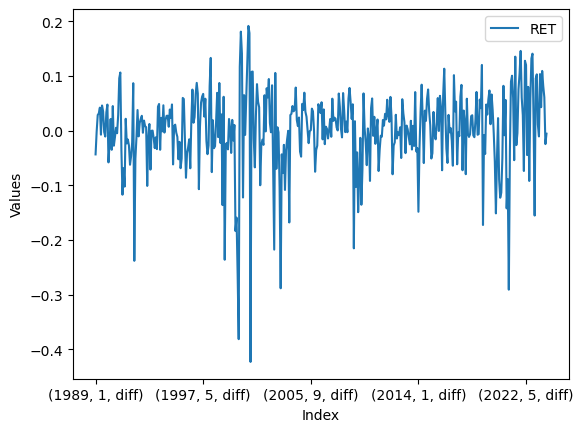

In [126]:
import matplotlib.pyplot as plt
meanret_diff.plot(kind='line')
plt.xlabel('Index')
plt.ylabel('Values')
plt.show()

In [127]:
# Monthly Mean Portfolio Returns for accrual rank
meanret = merged_data.groupby(['year','month', 'ROE_rank'])['RET'].mean().to_frame()   # Calculating average return for each decile (according to accrual ratio) for each month
meanret

RET
year month ROE_rank          
1989 1     0.0       0.102726
           1.0       0.093846
           2.0       0.071661
           3.0       0.056514
           4.0       0.067381
...                       ...
2023 12    5.0       0.087522
           6.0       0.111329
           7.0       0.117985
           8.0       0.098527
           9.0       0.084734

[4182 rows x 1 columns]

Are bigger accrual stocks expected to bigger returns? Why?

In [128]:
# Compute the difference between extreme portfolio returns and the Global mean for accrual_rank
meanret = meanret.unstack(level = -1).copy()                                       # Unstacking the grouped dataframe
meanret[('RET', 'diff')] = meanret[('RET', 9)] -  meanret[('RET', 0)]              # Calculating the long short returns of the portfolio by substracting "rank 0" avg. return from "rank 9" avg. return

nmon = len(meanret)                                                                # nmon in number of months
meanret = meanret.stack(level = -1).copy()                                         # Stacking the dataframe to year-month index level

# Overall Portfolio Returns Statistics
global_mean_ROE = meanret.groupby('ROE_rank')['RET'].agg([np.mean, np.std])                # mean and standard deviation of regression coefficients
global_mean_ROE['t-stat'] =np.sqrt(nmon - 1) *  global_mean_ROE['mean']/global_mean_ROE['std'] # t-statistics calculation
global_mean_ROE



C:\Users\ctlan\AppData\Local\Temp\ipykernel_21780\1397112305.py:9: FutureWarning: The provided callable <function mean at 0x0000022EE24D1900> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  global_mean_ROE = meanret.groupby('ROE_rank')['RET'].agg([np.mean, np.std])                # mean and standard deviation of regression coefficients
C:\Users\ctlan\AppData\Local\Temp\ipykernel_21780\1397112305.py:9: FutureWarning: The provided callable <function std at 0x0000022EE24D1A20> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  global_mean_ROE = meanret.groupby('ROE_rank')['RET'].agg([np.mean, np.std])                # mean and standard deviation of regression coefficients


,mean,std,t-stat
ROE_rank,,,
0.0,0.007044,0.098798,1.459442
1.0,0.011207,0.085780,2.674346
2.0,0.011717,0.070053,3.423750
3.0,0.011406,0.058721,3.975871
4.0,0.010905,0.051609,4.325374
5.0,0.011106,0.048069,4.729347
6.0,0.011019,0.046432,4.857821
7.0,0.011245,0.049636,4.637391
8.0,0.011490,0.051821,4.538413


Note: Small accrual stocks (or most negative accruals) earn bigger returns.



In [129]:
#combine scores - ensure that bigger score implies better signal
merged_data['ROA_pct_rank']= merged_data.groupby(['year','month'])['ROA'].rank(pct = True)
merged_data['ROE_pct_rank']= merged_data.groupby(['year','month'])['ROE'].rank(ascending=False, pct = True) # why is ascending = False?
merged_data['combined_pct_rank'] = merged_data['ROA_pct_rank'] + merged_data['ROE_pct_rank']
merged_data.dropna(subset = ['RET', 'combined_pct_rank'], how = 'any', inplace = True)   #Drop only observations where relevant variables are nan
merged_data = merged_data.loc[merged_data.year >= 2000].copy()
merged_data

,PERMNO,PRIMEXCH,date,RET,PRC,SHROUT,marketcap,year,month,datadate,ceq,ni,at,ROA,ROE,ROA_rank,ROE_rank,ROA_pct_rank,ROE_pct_rank,combined_pct_rank
773808,10866,N,2000-01-31,-0.265487,10.375,18258.0,2.578942e+05,2000,1,19990131.0,217.174,23.669,655.232,0.036123,0.108986,6,6.0,0.615594,0.397028,1.012622
773809,81015,Q,2000-01-31,0.294118,1.375,22641.0,2.405606e+04,2000,1,19981231.0,31.553,4.799,237.830,0.020178,0.152093,5,7.0,0.522448,0.241412,0.763860
773810,76415,Q,2000-01-31,0.119534,6.000,3541.0,1.897756e+04,2000,1,19981231.0,13.278,-0.036,16.071,-0.002240,-0.002711,3,3.0,0.318262,0.696118,1.014379
773811,71395,N,2000-01-31,0.037037,12.250,17878.0,2.111839e+05,2000,1,19981231.0,132.377,10.233,489.662,0.020898,0.077302,5,4.0,0.526761,0.510305,1.037067
773812,72119,A,2000-01-31,0.187500,4.750,5104.0,2.041600e+04,2000,1,19981231.0,9.641,-1.548,17.099,-0.090532,-0.160564,1,1.0,0.192363,0.808116,1.000479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072636,19880,N,2023-12-29,0.248681,75.720,78823.0,4.779827e+06,2023,12,20221231.0,2737.329,33.354,9293.259,0.003589,0.012185,4,4.0,0.482257,0.540264,1.022520
2072637,87487,Q,2023-12-29,0.110769,7.220,386791.0,2.514142e+06,2023,12,20221231.0,669.645,48.712,3074.971,0.015841,0.072743,5,5.0,0.597816,0.446542,1.044359
2072638,11174,Q,2023-12-29,-0.051333,75.770,6383.0,5.098102e+05,2023,12,20230430.0,498.447,20.392,1420.431,0.014356,0.040911,5,4.0,0.587125,0.501592,1.088717
2072639,17879,Q,2023-12-29,-0.154811,0.600,28814.0,2.045506e+04,2023,12,20221231.0,11.754,-13.071,13.127,-0.995734,-1.112047,0,1.0,0.055278,0.895814,0.951092


In [130]:
n_cut = 10
merged_data['combined_rank'] = merged_data.groupby(['year','month'])['combined_pct_rank'].transform(lambda x: pd.qcut(x, n_cut, duplicates='drop',labels=False)) # Calculating Ranks based on combined_pct_rank
meanret = merged_data.groupby(['year','month', 'combined_rank'])['RET'].mean().to_frame()   # Calculating average return for each decile (according to accrual ratio) for each month


In [131]:
# Compute the difference between extreme portfolio returns and the Global mean for combined_pct_rank
meanret = meanret.unstack(level = -1).copy()                                       # Unstacking the grouped dataframe
meanret[('RET', 'diff')] = meanret[('RET', n_cut - 1)] -  meanret[('RET', 0)]              # Calculating the long short returns of the portfolio by substracting "rank 0" avg. return from "rank 9" avg. return

nmon = len(meanret)                                                                # nmon in number of months
meanret = meanret.stack(level = -1).copy()                                         # Stacking the dataframe to year-month index level

# Overall Portfolio Returns Statistics
global_mean_combined = meanret.groupby('combined_rank')['RET'].agg([np.mean, np.std])                # mean and standard deviation of regression coefficients
global_mean_combined['t-stat'] =np.sqrt(nmon - 1) *  global_mean_combined['mean']/global_mean_combined['std'] # t-statistics calculation
global_mean_combined



C:\Users\ctlan\AppData\Local\Temp\ipykernel_21780\1980693962.py:9: FutureWarning: The provided callable <function mean at 0x0000022EE24D1900> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  global_mean_combined = meanret.groupby('combined_rank')['RET'].agg([np.mean, np.std])                # mean and standard deviation of regression coefficients
C:\Users\ctlan\AppData\Local\Temp\ipykernel_21780\1980693962.py:9: FutureWarning: The provided callable <function std at 0x0000022EE24D1A20> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  global_mean_combined = meanret.groupby('combined_rank')['RET'].agg([np.mean, np.std])                # mean and standard deviation of regression coefficients


,mean,std,t-stat
combined_rank,,,
0,0.009761,0.060279,2.743327
1,0.010081,0.053134,3.214191
2,0.008437,0.080598,1.773323
3,0.009286,0.080478,1.954741
4,0.009946,0.073562,2.290453
5,0.010839,0.066655,2.754832
6,0.009821,0.063879,2.604592
7,0.010935,0.062939,2.943263
8,0.009415,0.060042,2.656402


In [135]:
meanret

RET
year month combined_rank          
2000 1     0              0.022750
           1             -0.028422
           2              0.144003
           3              0.142915
           4              0.076753
...                            ...
2023 12    6              0.114866
           7              0.105513
           8              0.098764
           9              0.102610
           diff          -0.020523

[3168 rows x 1 columns]

In [137]:
df = meanret.reset_index()

# The DataFrame should now have 'year' and 'month' as columns that can be forward-filled
df['year'] = df['year'].ffill()
df['month'] = df['month'].ffill()

df

,year,month,combined_rank,RET
0,2000,1,0,0.022750
1,2000,1,1,-0.028422
2,2000,1,2,0.144003
3,2000,1,3,0.142915
4,2000,1,4,0.076753
...,...,...,...,...
3163,2023,12,6,0.114866
3164,2023,12,7,0.105513
3165,2023,12,8,0.098764
3166,2023,12,9,0.102610


## how to avoid Explain how your code avoids any look-ahead bias
To avoid look-ahead bias, the code calculates lagged market capitalization using Returns['marketcap'] = Returns.groupby('PERMNO')['marketcap'].shift(). This technique ensures that only information available at the end of the prior period is used, not the current period’s data. Stocks are sorted by date, and calculations are performed using data from current_date - 1, thereby preventing the use of future information in the analysis.


# calculate the alpha and beta

In [ ]:
# Importing Necessary Python Libraries
import pandas as pd
import statsmodels.api as sm

In [139]:

Mkt_Risk_freeRate = pd.read_csv(r"C:\Users\ctlan\OneDrive\desktop\FIN\dataset\risk\Market_Riskfree_2312.csv")     # read market returns and risk-free rate
Mkt_Risk_freeRate['mkt_excess_returns'] = Mkt_Risk_freeRate['Market'] - Mkt_Risk_freeRate['RiskfreeRate'] #compute market excess returns
asset_returns = pd.merge(df, Mkt_Risk_freeRate, how = "inner", on = ['year', 'month'])
asset_returns['excess_returns'] = asset_returns['RET'] - asset_returns['RiskfreeRate'] #compute asset excess returns
asset_returns.loc[asset_returns['combined_rank'] == 'diff',  'excess_returns'] = asset_returns['RET']  #Long - short returns  for diff
asset_returns.head(11)

,year,month,combined_rank,RET,Market,RiskfreeRate,mkt_excess_returns,excess_returns
0,2000,1,0,0.022750,-0.0433,0.0041,-0.0474,0.018650
1,2000,1,1,-0.028422,-0.0433,0.0041,-0.0474,-0.032522
2,2000,1,2,0.144003,-0.0433,0.0041,-0.0474,0.139903
3,2000,1,3,0.142915,-0.0433,0.0041,-0.0474,0.138815
4,2000,1,4,0.076753,-0.0433,0.0041,-0.0474,0.072653
5,2000,1,5,0.068404,-0.0433,0.0041,-0.0474,0.064304
6,2000,1,6,0.040353,-0.0433,0.0041,-0.0474,0.036253
7,2000,1,7,0.034043,-0.0433,0.0041,-0.0474,0.029943
8,2000,1,8,0.037042,-0.0433,0.0041,-0.0474,0.032942
9,2000,1,9,0.054009,-0.0433,0.0041,-0.0474,0.049909


In [149]:
asset_returns['combined_rank'] = asset_returns['combined_rank'].astype(str)

In [150]:
ranks = set((asset_returns['combined_rank'])) # determines ids for assets in the data
ranks_list = list(sorted(ranks))
ranks_list

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'diff']

In [153]:
import statsmodels.api as sm
asset_returns['constant'] = 1 #add constant to the regression to get the intercept
for decile in ranks_list:                                                         #Loop through the date to pick one rank at a time and estimate alpha and beta for that portfolio
    x = asset_returns[['constant', 'mkt_excess_returns', ]].loc[asset_returns['combined_rank'] == decile].copy()
    y = asset_returns['excess_returns'].loc[asset_returns['combined_rank'] == decile].copy()
    model = sm.OLS(y,x)
    results = model.fit()
 #Print out the regression estimates for one portfolio at a time. Then print the corresponding t-statistics
    print('************************************************')
    print('Decile:' , decile)
    print('**************** estimates of alpha and beta ****************' )
    print(results.params) #gets the parameters                                  #The coefficient on the constant(also referred to as the 'intercept')) is alpha
                                                                                # The coefficient on 'mkt_excess_returns' is beta

    print('******** t-statistics for alpha and beta ***********' )              #Use the t-stats on the constant to test whether alpha is signficantly different from zero.
                                                                                # The coefficient on 'mkt_excess_returns' is beta
    print(results.tvalues)

************************************************
Decile: 0
**************** estimates of alpha and beta ****************
constant              0.002498
mkt_excess_returns    1.080555
dtype: float64
******** t-statistics for alpha and beta ***********
constant               1.237186
mkt_excess_returns    24.885069
dtype: float64
************************************************
Decile: 1
**************** estimates of alpha and beta ****************
constant              0.003442
mkt_excess_returns    0.966314
dtype: float64
******** t-statistics for alpha and beta ***********
constant               2.002405
mkt_excess_returns    26.140519
dtype: float64
************************************************
Decile: 2
**************** estimates of alpha and beta ****************
constant             -0.000294
mkt_excess_returns    1.349069
dtype: float64
******** t-statistics for alpha and beta ***********
constant              -0.096458
mkt_excess_returns    20.601791
dtype: float64
**********